In [30]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy import stats
import matplotlib.pyplot as plt

### get SPY data

In [32]:
spy = yf.download(
        tickers = 'SPY',
        interval = '1d',
        period = '5y',
        threads = True,
    )

returns = spy['Adj Close'].pct_change().fillna(0).to_numpy()

[*********************100%***********************]  1 of 1 completed


### Monte Carlo GBM

In [3]:
S0 = spy['Adj Close'][-1]
dt = 1
T = 1
N = T/dt
mu = np.mean(returns)
sigma = np.std(returns)
n = 10000
sim_returns = np.zeros(n)

for i in range(n):
    S_t = S0
    for t in range(T):
        z = np.random.normal(0, 1, 1)
        S_t = S_t*np.exp((mu-sigma*sigma/2)*dt + sigma*np.sqrt(dt)*z)
    sim_returns[i] = (S_t-S0)/S0
sim_returns

print("S0:",S0,"\nN:",N,"\nmu:",mu,"\nsigma:",sigma)
print("\nsimulation mu:",np.mean(sim_returns))
print("simulation sigma:",np.std(sim_returns))

S0: 400.3399963378906 
N: 1.0 
mu: 0.00048591151051303024 
sigma: 0.013515888506551624

simulation mu: 0.0004946922214437542
simulation sigma: 0.01340580703182934


### VaR (Variance-Cov)

In [4]:
S_AND_P_URL = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

def get_s_and_p_tickers() -> list:
    '''
    Get a list of all tickers currently in the S&P500 index.
    '''
    return pd.read_html(S_AND_P_URL)[0]['Symbol'].tolist()
    

Get all S&P 500 stock prices

In [5]:
data = yf.download(
        tickers = get_s_and_p_tickers(),
        period = '5y',
        interval = '1d',
        group_by = 'ticker',
        threads = True,
    )

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted


In [6]:
data = data.xs("Adj Close",level=1,axis=1)

In [7]:
data.head()

,FLT,BXP,RE,PLD,AXP,CTVA,PXD,CE,O,LYV,...,GL,DTE,TFX,HPE,GIS,EMN,AEE,PM,MRO,ILMN
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-14 00:00:00,188.500000,106.347771,195.177856,58.044247,90.474792,NaN,130.980347,94.915123,44.407269,42.810001,...,85.274635,82.185570,243.836426,12.092266,46.994255,78.120010,53.186283,81.655235,14.204875,210.850006
2017-12-15 00:00:00,190.110001,108.613876,199.131607,58.496391,91.750664,NaN,130.352966,95.642273,44.742455,42.630001,...,85.994400,82.544960,246.594040,12.236626,47.630566,77.930000,53.282459,83.171844,14.101535,216.550003
2017-12-18 00:00:00,190.679993,109.914803,196.540573,58.390003,92.830963,NaN,133.263992,97.401772,45.054264,43.560001,...,86.243889,81.035927,246.339828,12.652723,48.392441,79.234154,52.819061,81.875145,14.496115,217.289993
2017-12-19 00:00:00,188.860001,108.135490,196.235794,56.191296,92.337372,NaN,134.008469,96.934975,43.924004,44.060001,...,86.502991,79.468567,248.608490,12.567804,48.250107,79.743736,52.014660,81.988884,15.050406,214.740005
2017-12-20 00:00:00,190.169998,107.304581,194.110977,55.898724,91.741318,NaN,139.864029,96.701569,43.347179,43.369999,...,86.771698,78.914536,250.114456,12.491383,49.196190,80.348312,51.315189,79.936279,15.332248,216.440002


In [8]:
returns = data.pct_change().fillna(0) # get returns of Adj. Close price

In [9]:
# drop the entries that are Null
missing_percentage = data.isnull().mean().sort_values(ascending=False)
dropped_list = sorted(list(missing_percentage[missing_percentage > 0].index))
data.drop(labels=dropped_list, axis=1, inplace=True)

In [10]:
X = data.T

In [11]:
mean_change = np.mean(X,1) * 256
total_vol = np.std(X,1) * np.sqrt(256)

In [12]:
returns.T

Date,2017-12-14,2017-12-15,2017-12-18,2017-12-19,2017-12-20,2017-12-21,2017-12-22,2017-12-26,2017-12-27,2017-12-28,...,2022-12-01,2022-12-02,2022-12-05,2022-12-06,2022-12-07,2022-12-08,2022-12-09,2022-12-12,2022-12-13,2022-12-14
FLT,0.0,0.008541,0.002998,-0.009545,0.006936,0.005311,-0.003766,0.004620,0.000470,0.010187,...,0.000408,-0.013654,-0.012138,-0.030693,0.005718,-0.011103,-0.004990,0.033197,0.008864,-0.000837
BXP,0.0,0.021308,0.011978,-0.016188,-0.007684,-0.007118,0.003151,0.009031,0.004670,0.004287,...,-0.005966,-0.013119,-0.040447,-0.036993,-0.005203,0.019538,0.005131,0.016064,0.005319,0.020282
RE,0.0,0.020257,-0.013012,-0.001551,-0.010828,0.008914,0.002335,0.003562,0.001138,0.011774,...,-0.022489,0.009475,-0.008636,0.018664,-0.011314,0.002373,-0.003536,-0.000060,-0.003579,-0.017730
PLD,0.0,0.007790,-0.001819,-0.037656,-0.005207,-0.000634,0.013014,-0.000157,0.007208,0.007467,...,-0.005858,-0.001366,-0.022918,0.002976,0.012216,0.013793,-0.010884,0.014701,0.025926,0.006772
AXP,0.0,0.014102,0.011774,-0.005317,-0.006455,-0.000101,0.002436,-0.001722,0.005681,0.005750,...,-0.000571,-0.004762,-0.004274,-0.008842,0.000453,-0.004200,-0.001427,0.022157,0.001335,-0.013078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EMN,0.0,-0.002432,0.016735,0.006431,0.007581,-0.001290,-0.002798,0.003562,-0.004840,0.009619,...,-0.002309,0.012729,-0.016453,-0.011269,-0.004230,0.006018,-0.001056,0.015381,0.018733,-0.017707
AEE,0.0,0.001808,-0.008697,-0.015229,-0.013448,-0.005453,0.005482,-0.006645,0.006861,0.007666,...,-0.006941,-0.007441,-0.008973,0.007270,-0.007790,0.018127,0.004876,0.023474,0.001874,-0.008254
PM,0.0,0.018573,-0.015591,0.001389,-0.025035,0.003928,-0.001241,-0.005160,0.005763,0.000955,...,0.027992,0.017958,-0.007862,-0.017878,0.002460,0.001767,0.000294,0.004996,-0.002729,0.002639
MRO,0.0,-0.007275,0.027981,0.038237,0.018726,0.044730,-0.008797,0.021302,-0.014484,0.003527,...,-0.017630,-0.011632,-0.041022,-0.037518,-0.001457,-0.020795,-0.024963,0.038594,0.018396,0.001445


In [37]:
corr = returns.corr()

In [35]:
covariance = returns.cov()

In [40]:
z = stats.norm.ppf(0.01)
VaR_ret = z*sigma
VaR = -1*VaR_ret*S0
print("Variance-Covariance 1 day 1% VaR: ", VaR)

Variance-Covariance 1 day 1% VaR:  12.420395241350734


### MC VaR

In [13]:
num_paths = 100000
sim_returns = np.zeros(num_paths)

for i in range(num_paths):
    S_t = S0
    for t in range(T):
        z = np.random.normal(0, 1, 1)
        S_t = S_t*np.exp((mu-sigma*sigma/2)*dt + sigma*np.sqrt(dt)*z)
    sim_returns[i] = (S_t-S0)/S0


In [14]:
sim_returns.sort() # find the 1000th worst returns

In [15]:
print("MC 1 day 1% VaR:", sim_returns[999]*S0*-1)

MC 1 day 1% VaR: 12.236435615090102


### Historical VaR

In [16]:
returns = spy['Adj Close'].pct_change().fillna(0).to_numpy()

# use the 
pos = int(len(returns)*0.01)

returns.sort()
Bootstrap_VaR_ret = returns[pos]

print("Historical Bootstrap 1 day 1% VaR: ", -1*Bootstrap_VaR_ret*S0)

Historical Bootstrap 1 day 1% VaR:  15.200152850085498


### GBM Option Pricing

In [110]:
returns = spy['Adj Close'].pct_change().fillna(0).to_numpy()

def gbm_option_pricer(strike, returns, last_close):
    dt = 1
    n = 10000
    r = 0
    sigma = np.std(returns) * np.sqrt(252)
    K = strike
    S0 = last_close
    B = np.random.normal(0, dt**0.5, size=n)
    St = S0*np.exp((r-sigma**2/2)*dt+sigma*B)
    E = np.maximum(St-K, 0) * np.exp(-r*dt)
    
    return np.mean(E), St

gbm_450_call_price, gbm_path = gbm_option_pricer(450, returns, spy['Adj Close'].iloc[-1])

### Heston Option Pricing

parameter estimation

In [40]:
rolling_std = spy['Adj Close'].pct_change().rolling(10).std().fillna(0).values

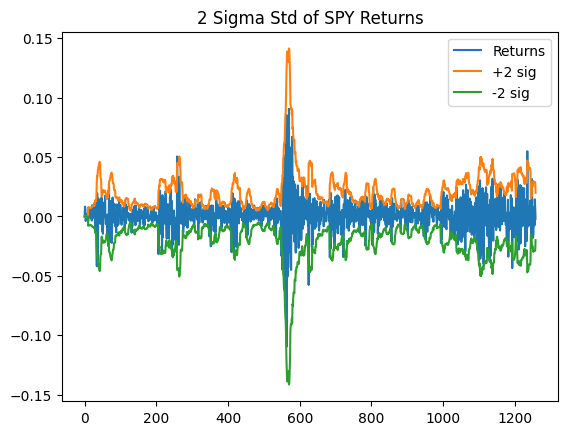

In [45]:
returns = spy['Adj Close'].pct_change().fillna(0).to_numpy()

plt.plot(returns, label='Returns')
plt.plot(rolling_std*2, label='+2 sig')
plt.plot(-rolling_std*2, label='-2 sig')
plt.title('2 Sigma Std of SPY Returns')
plt.legend()

In [81]:
# number of simulations
M = 10000

# trading days in the year
days = 252

# years
T = 1

# number of time steps in simulation
N = int(T * days)

# Time Step
dt = T/N

In [99]:
#Heston Params

# rate of mean reversion of variance
kappa = 3    

# long-term mean of variance
theta = np.power(rolling_std.mean()*np.sqrt(days),2)

# vol of vol
sigma = rolling_std.std()*np.sqrt(days)

# correlation of variance with returns
rho = np.corrcoef(rolling_std, returns)[0][1]

print('Rho:',rho)
print('Sigma:',sigma)
print('Kappa:',kappa)
print('Theta:',theta)

Rho: -0.0074829931874403266
Sigma: 0.13139814268809485
Kappa: 3
Theta: 0.029692980755221973


In [83]:
# Create a Mulivariate Normal ~N(0,Sigma=Rho)

mu = np.array([0, 0])
cov = np.eye(2)
cov[[0,1],[1,0]] = rho
Z = np.random.multivariate_normal(mu, cov, (N, M))

In [84]:
# current price
S0 = spy['Adj Close'].iloc[-1]

# initial variance
v0 = np.power(rolling_std[0]*np.sqrt(days),2)

# data structure to store price and var
S = np.full(shape=(N+1, M), fill_value=S0)
v = np.full(shape=(N+1, M), fill_value=v0)

In [85]:
# Run the Simulation

for i in range(1, N+1):
    S[i] = S[i-1] * np.exp((r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1, :, 0])
    v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1, :, 1], 0)

In [106]:
# risk-free rate
rate = 0 
delta = 1/days

# Strike Price
K = 450

E = np.maximum(S[-1,:]-K, 0) * np.exp(-r*delta)
heston_450_call_price = np.mean(E)

### GBM/Heston Comparison

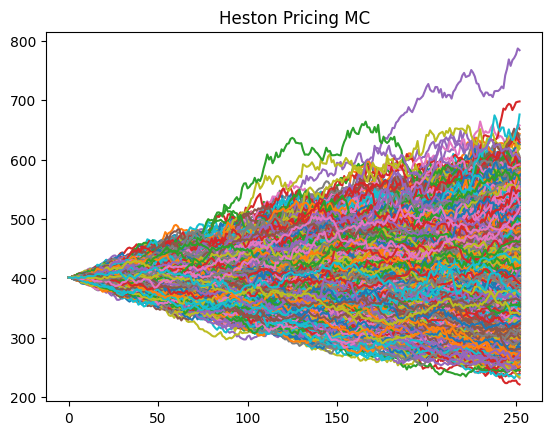

In [102]:
plt.plot(S)
plt.title('Heston Pricing MC')
plt.show()

In [107]:
print('Price of a 450 strike call option according to Heston Model:', heston_450_call_price)

Price of a 450 strike call option according to Heston Model: 7.0346119442827035


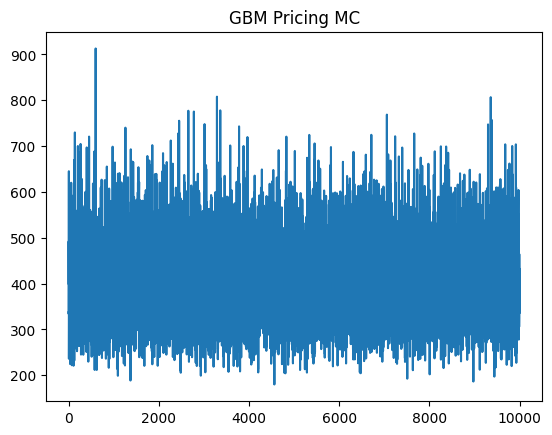

In [111]:
plt.plot(gbm_path.T)
plt.title('GBM Pricing MC')
plt.show()

In [112]:
print('Price of a 450 strike call option according to GBM Model:', gbm_450_call_price)

Price of a 450 strike call option according to GBM Model: 16.696837807837127


I beleive the Heston Model is a more accurate pricer because it takes many paths that the market can go in <br>
into account (i.e. it is a stochastic pricer). As opposed to GBM that generates a single path based on a standard normal random variable

### Knock Out Barrier Option

In [163]:
upper = 450
lower = 350
K = 400

# Find all simulations that stayed in bounds and price option on those
mask = (S > lower) & (S < upper)

In [170]:
knock_out = mask*S

In [160]:
E = np.maximum(knock_out[-1,:]-K, 0) * np.exp(-r*delta)

In [161]:
heston_KO_price = np.mean(E)

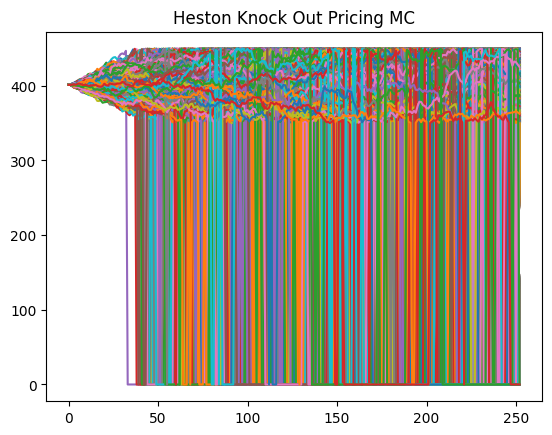

In [162]:
plt.plot(knock_out)
plt.title('Heston Knock Out Pricing MC')
plt.show()

In [176]:
heston_KO_price

5.8796414696265185